Y_data: 20640
y_data: 19648
y_data: 18665
[0.32477544 0.32475738 0.32468205 0.3245989  0.32446688 0.32441684
 0.32437674 0.32432433 0.32430599 0.32462218 0.35251819 0.45652149
 0.5355167 ]
Best alpha: 50
Predicción de precios de casas sin ruido:
MSE: 0.33805290443475283
MAE: 0.43378831988273536
RMSE: 0.5814231715667624
R2: 0.6442733548779136


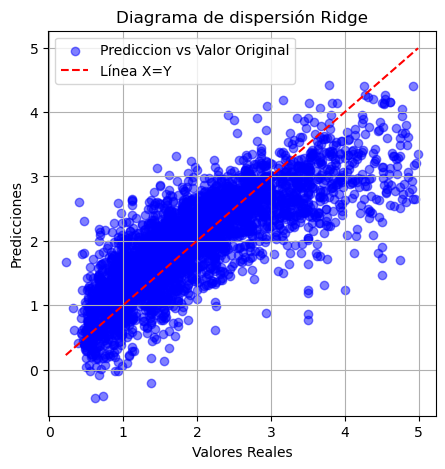


Epsilon = 1e-07
Error del ruido:
MAE: 2801636487298545.5
MAE: 13262357.771475486
RMSE: 52930487.31400973
R2: -1163243326766233.2

Predicción de precios con ruido:
MSE: 0.4953466451143639
MAE: 0.5361450600350541
RMSE: 0.7038086708149907
R2: 0.4787561416351531

Epsilon = 0.0001
Error del ruido:
MAE: 2770597944.676884
MAE: 13228.620088574376
RMSE: 52636.46972087779
R2: -1150356080.1364448

Predicción de precios con ruido:
MSE: 0.4953281880886425
MAE: 0.5361169937180174
RMSE: 0.7037955584462312
R2: 0.478775563612461

Epsilon = 0.1
Error del ruido:
MAE: 2813.9477344119086
MAE: 13.271307016751697
RMSE: 53.0466562038731
R2: -1167.3549735175936

Predicción de precios con ruido:
MSE: 0.4952513669879976
MAE: 0.536119909934463
RMSE: 0.7037409800402401
R2: 0.4788564009963394

Epsilon = 0.5
Error del ruido:
MAE: 113.88909271088073
MAE: 2.690978927417077
RMSE: 10.671883278544641
R2: -46.28690809389637

Predicción de precios con ruido:
MSE: 0.49509858565273895
MAE: 0.5360023358348517
RMSE: 0.7036324

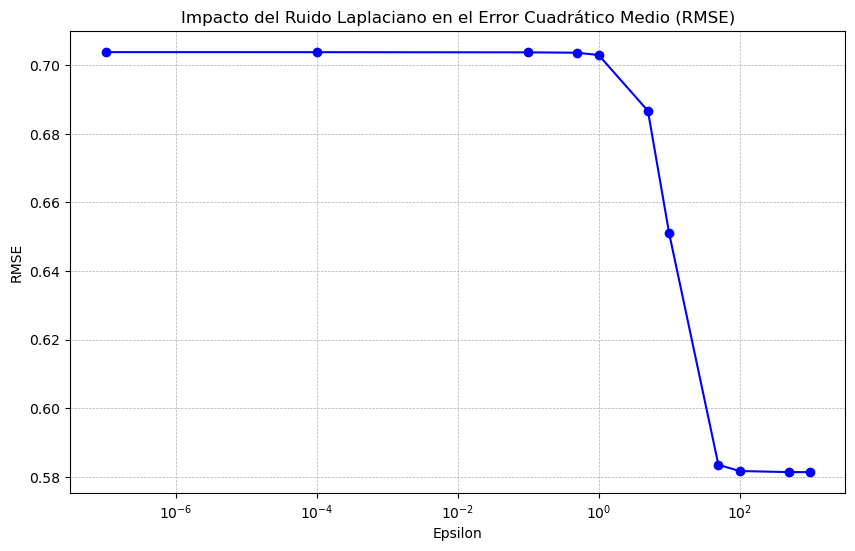

In [47]:
import numpy as np
import ModeloBase
from ModeloBase import read_data_model, add_laplace_noise, rmse
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import Ridge
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

np.random.seed(42) 

all_data = fetch_california_housing()
X_train_val, X_val, X_test, Y_train_val, Y_val, Y_test = read_data_model(all_data, 'MedInc')

# Entrenamos el scanner con los datos train_val para evitar fuga de datos antes del entrenamiento
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hiperparametros
alpha = [0.1, 1, 5, 10, 20, 25, 30, 40, 50,100, 1000, 5000, 10000]
mse1 = []

for i in alpha:
    model_Ridge = Ridge(i)
    model_Ridge.fit(X_train_val_scaled, Y_train_val)
    Y_predict = model_Ridge.predict(X_val_scaled)
    mse1.append(mse(Y_val, Y_predict))

print(np.array(mse1))

# Seleción del mejor alpha 
best_alpha = alpha[np.argmin(mse1)]
print(f"Best alpha: {best_alpha}")

# Entrenamiento del modelo original sin ruido
model_original = Ridge(best_alpha)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluación del modelo original sin ruido
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
RMSE_original = rmse(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print("Predicción de precios de casas sin ruido:")
print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"RMSE: {RMSE_original}")
print(f"R2: {R2_original}")

# Diagrama de dispersión de predicciones vs valores originales
plt.figure(figsize=(5, 5))
plt.scatter(Y_test, Y_predict, alpha=0.5, color='blue', label='Prediccion vs Valor Original')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Línea X=Y')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Diagrama de dispersión Ridge')
plt.legend()
plt.grid(True)

# Guardar la imagen antes de mostrarla
plt.savefig('diagrama_dispersion_Ridge.png', dpi=300)
plt.show()

# Iterar sobre diferentes valores de epsilon
epsilon_values = [0.0000001, 0.0001, 0.1, 0.5, 1.0, 5 , 10, 50, 100, 500, 1000]
results = []

for epsilon in epsilon_values:
    print(f"\nEpsilon = {epsilon}")

    # Paso 1: Agregar ruido laplaciano a la columna de ingresos en el conjunto de entrenamiento
    X_train_val_noisy = add_laplace_noise(X_train_val, epsilon)

    MSE_original = mse(X_train_val, X_train_val_noisy)
    MAE_original = mae(X_train_val, X_train_val_noisy)
    RMSE_original = rmse(X_train_val, X_train_val_noisy)
    R2_original = r2(X_train_val, X_train_val_noisy)

    print("Error del ruido:")
    print(f"MAE: {MSE_original}")
    print(f"MAE: {MAE_original}")
    print(f"RMSE: {RMSE_original}")
    print(f"R2: {R2_original}")

    # Paso 2: Entrenar el modelo utilizando los valores de ingresos con ruido
    scaler = StandardScaler()
    X_train_val_noisy_scaled = scaler.fit_transform(X_train_val_noisy)
    X_test_scaled = scaler.transform(X_test)

    model_noisy = Ridge(best_alpha)
    model_noisy.fit(X_train_val_noisy_scaled, Y_train_val)
    Y_predict = model_noisy.predict(X_test_scaled)

    # Paso 3: Evaluar el modelo entrenado con datos ruidosos usando el conjunto de validación original
    MSE_noisy = mse(Y_test, Y_predict)
    MAE_noisy = mae(Y_test, Y_predict)
    RMSE_noisy = rmse(Y_test, Y_predict)
    R2_noisy = r2(Y_test, Y_predict)

    print("\nPredicción de precios con ruido:")
    print(f"MSE: {MSE_noisy}")
    print(f"MAE: {MAE_noisy}")
    print(f"RMSE: {RMSE_noisy}")
    print(f"R2: {R2_noisy}")

    results.append((epsilon,MSE_noisy ,MAE_noisy, RMSE_noisy, R2_noisy))

# Mostrar los resultados
import pandas as pd
results_df = pd.DataFrame(results, columns=["Epsilon", "MSE", "MAE", "RMSE", "R2"])
print(results_df)

# Graficar el RMSE en función del valor de epsilon
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epsilon"], results_df["RMSE"], marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Usar escala logarítmica para epsilon
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('Impacto del Ruido Laplaciano en el Error Cuadrático Medio (RMSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('Ridge_rmse_vs_epsilon.png', dpi=300)
plt.show()
